In [101]:
%matplotlib inline

In [102]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels
from cpc.utils.misc import jhuBoundaryDetector, jchBoundaryDetector, kreukBoundaryDetector

In [103]:
sys.path.append(os.path.dirname(tr.__file__))

In [104]:
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline2/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine/checkpoint_49.pt'

In [105]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=2, CPCCTCNumMatched=12, CPCCTCReductionFactor=10, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='LSTM', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encoder_type='cpc', epsilon=1e-08, file_extension='.flac', gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=False, learningRate=0.

In [106]:
args.pathDB = '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100'
args.pathTrain = '/pio/gluster/data/ls-train-clean-100/train_split.txt'
args.pathVal = '/pio/gluster/data/ls-train-clean-100/test_split.txt'
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


Loaded from cache /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt successfully


10it [00:00, 203606.99it/s]

Checking length...
Done, elapsed: 0.007 seconds
Scanned 10 sequences in 0.01 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.112 secs


In [107]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)
label = label['phone']

In [108]:
EPS = 1e-7
segmentationParamRange = np.arange(0.01, 0.15, 0.01)
toleranceInFrames = 2

label = torch.cat([label[:, 0].view(-1, 1), label], dim=1)
trueBoundaries = torch.where(torch.diff(label.view(-1)) != 0)[0]
# Ensure that minibatch boundaries are preserved
seqEndIdx = torch.arange(0, encodedData.size(0)*encodedData.size(1) + 1, encodedData.size(1))
trueBoundaries = torch.unique(torch.cat((trueBoundaries, seqEndIdx)), sorted=True)

# For Kreuk
maxRval = 0
boundariesKreuk = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = kreukBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesKreuk = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("Kreuk")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JHU
maxRval = 0
boundariesJHU = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = jhuBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJHU = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JHU")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JCh
maxRval = 0
boundariesJCh = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = jchBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJCh = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JCh")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

--------------------------------------------------
Kreuk
--------------------------------------------------
Precision:	0.8333333134651184
Recall:	0.8235294222831726
F1:	0.8284023404121399
R:	0.8533365726470947
--------------------------------------------------
JHU
--------------------------------------------------
Precision:	0.7894737124443054
Recall:	0.7647058963775635
F1:	0.7768923044204712
R:	0.80921471118927
--------------------------------------------------
JCh
--------------------------------------------------
Precision:	1.0
Recall:	0.7058823704719543
F1:	0.8275861740112305
R:	0.7920274138450623


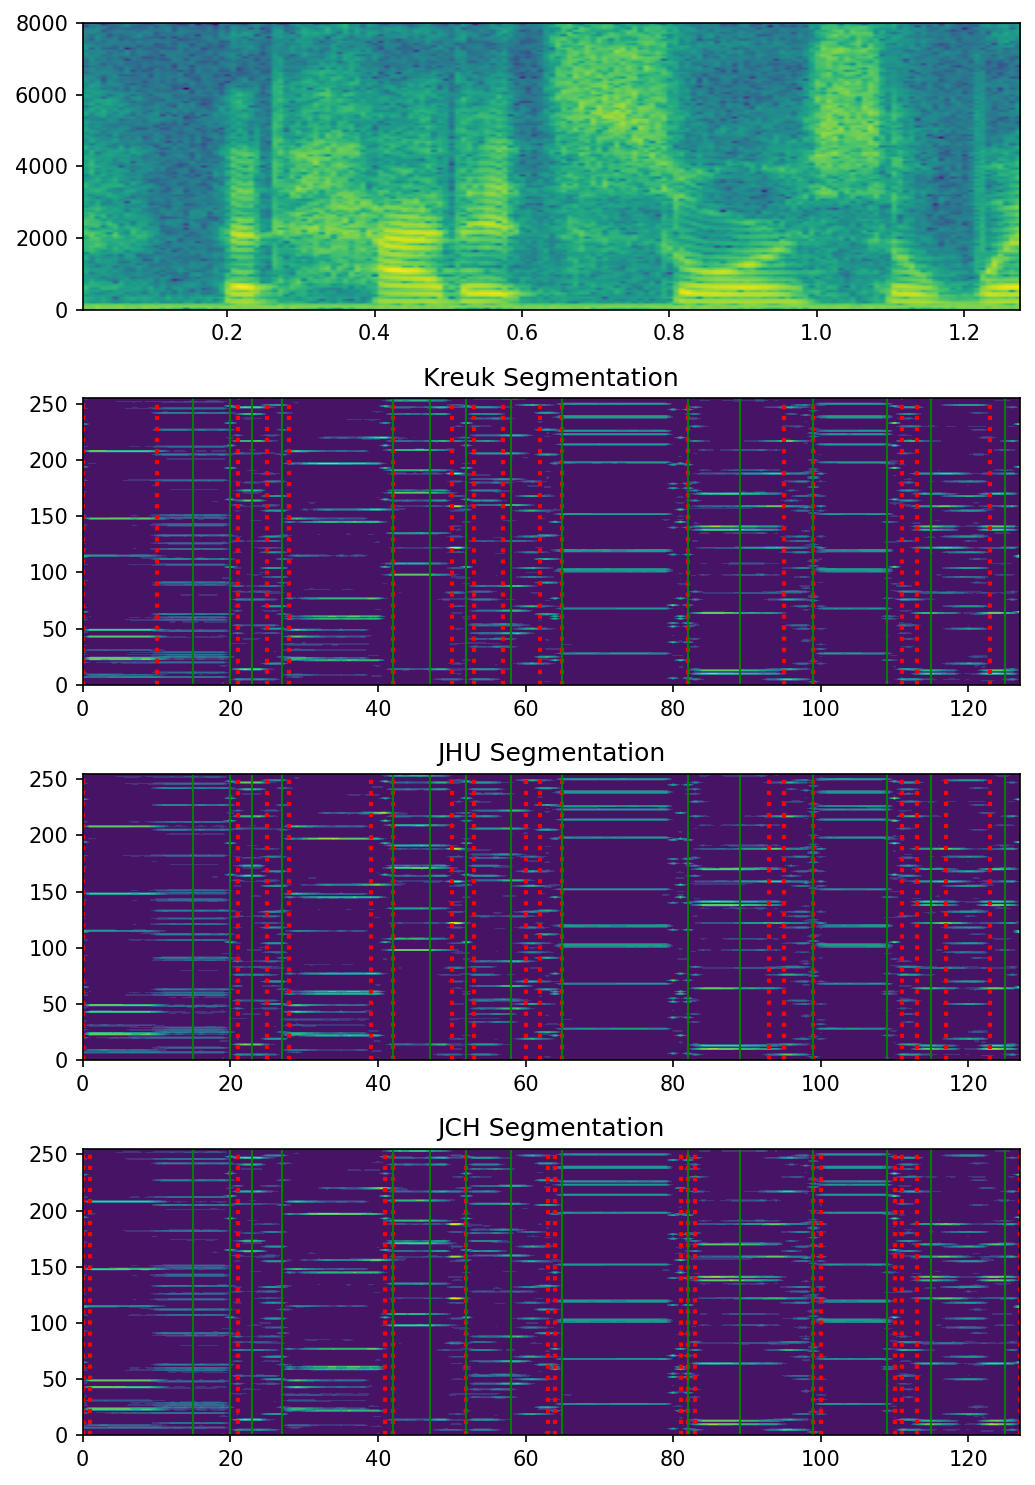

In [109]:
features = encodedData
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

waveform = batchData.cpu().numpy().reshape(-1)
x = np.arange(0, 128)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(7, 10), dpi=150)
plt.subplot(411)
plt.specgram(waveform, Fs=16000)
plt.subplot(412)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesKreuk.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("Kreuk Segmentation")
plt.subplot(413)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJHU.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JHU Segmentation")
plt.subplot(414)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJCh.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JCH Segmentation")
plt.tight_layout()
plt.savefig(CP.split('/')[-2] + '_comp_segmentations')

# Buckeye

In [110]:
phones2codes = {  # phonemes which should be the same for TIMIT
    'a': 0, 'aa': 1, 'aan': 2, 'ae': 3, 'aen': 4, 'ah': 0, 'ahn': 5, 'an': 5, 
    'ao': 6, 'aon': 7, 'aw': 8, 'awn': 9, 'ay': 10, 'ayn': 11, 'b': 12, 'ch': 13, 
    'd': 14, 'dh': 15, 'dx': 16, 'eh': 17, 'ehn': 18, 'el': 19, 'em': 20, 'en': 21, 
    'eng': 22, 'er': 23, 'ern': 24, 'ey': 25, 'eyn': 26, 'f': 27, 'g': 28, 'h': 29, 
    'hh': 29, 'hhn': 30, 'i': 31, 'id': 31, 'ih': 31, 'ihn': 32, 'iy': 33, 'iyih': 32, 
    'iyn': 32, 'jh': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'ng': 39, 'nx': 40, 
    'ow': 41, 'own': 42, 'oy': 43, 'oyn': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 
    'sh': 49, 't': 50, 'th': 51, 'tq': 46, 'uh': 52, 'uhn': 53, 'uw': 54, 'uwix': 54, 
    'uwn': 55, 'v': 56, 'w': 57, 'y': 58, 'z': 59, 'zh': 60, '-': 61, '###': 62,
    'x': 63, 'no': 64
}

codes2phones = {v: k for k, v in phones2codes.items()}

In [111]:
args.pathDB = '/pio/scratch/1/i325922/data/BUCKEYE/clean/all-clean'
args.pathTrain = '/pio/scratch/1/i325922/data/BUCKEYE/clean/train_split.txt'
args.pathVal = '/pio/scratch/1/i325922/data/BUCKEYE/clean/test_split.txt'
args.pathPhone = '/pio/scratch/1/i325922/data/BUCKEYE/clean/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

Loaded from cache /pio/scratch/1/i325922/data/BUCKEYE/clean/all-clean/_seqs_cache.txt successfully


10it [00:00, 187245.71it/s]

Checking length...
Done, elapsed: 0.003 seconds
Scanned 10 sequences in 0.00 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.341 secs


In [112]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)
label = label['phone']

In [113]:
import torch
EPS = 1e-7
segmentationParamRange = np.arange(0.01, 0.15, 0.01)
toleranceInFrames = 2

label = torch.cat([label[:, 0].view(-1, 1), label], dim=1)
trueBoundaries = torch.where(torch.diff(label.view(-1)) != 0)[0]
# Ensure that minibatch boundaries are preserved
seqEndIdx = torch.arange(0, encodedData.size(0)*encodedData.size(1) + 1, encodedData.size(1))
trueBoundaries = torch.unique(torch.cat((trueBoundaries, seqEndIdx)), sorted=True)

# For Kreuk
maxRval = 0
boundariesKreuk = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = kreukBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesKreuk = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("Kreuk")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JHU
maxRval = 0
boundariesJHU = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = jhuBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJHU = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JHU")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JCh
maxRval = 0
boundariesJCh = None
for segmentationParam in segmentationParamRange:
    predictedBoundaries = jchBoundaryDetector(encodedData, segmentationParam, justSegmenter=True).cpu()
    precisionCounter = 0
    recallCounter = 0
    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)
    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        recallCounter += (minDist <= toleranceInFrames)
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJCh = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JCh")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

--------------------------------------------------
Kreuk
--------------------------------------------------
Precision:	0.8399999737739563
Recall:	0.8999999761581421
F1:	0.8689654469490051
R:	0.8779457807540894
--------------------------------------------------
JHU
--------------------------------------------------
Precision:	0.8333333134651184
Recall:	0.8999999761581421
F1:	0.8653844594955444
R:	0.8723292350769043
--------------------------------------------------
JCh
--------------------------------------------------
Precision:	1.0
Recall:	0.4000000059604645
F1:	0.5714285373687744
R:	0.5757359266281128


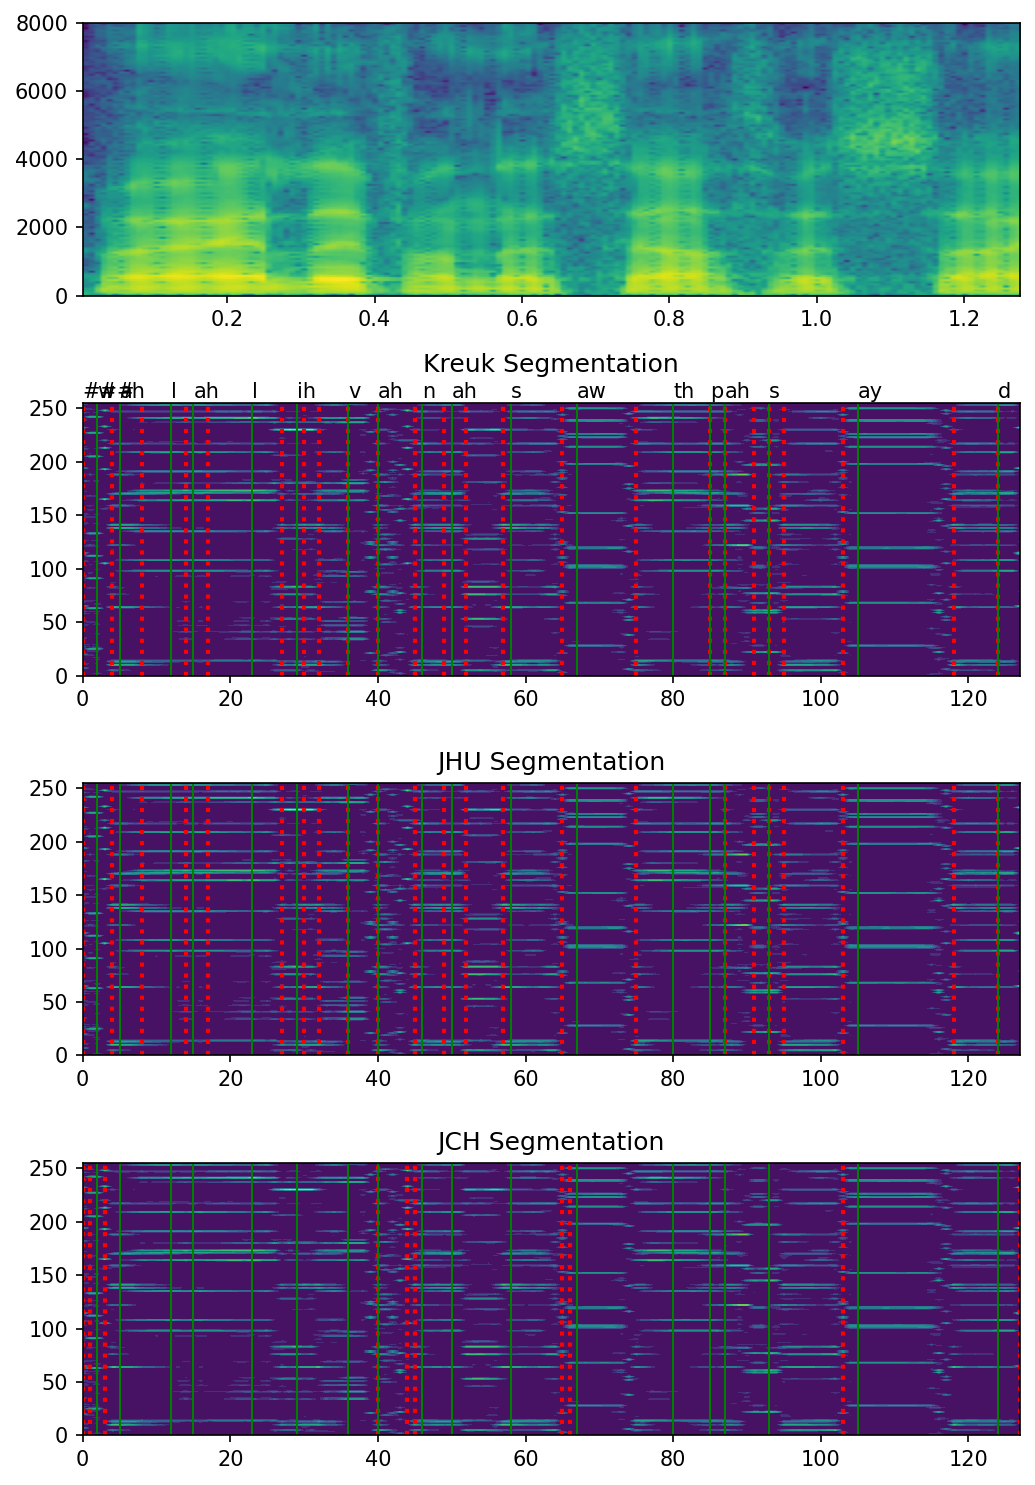

In [114]:
phones = label[0, trueBoundaries[:-1] + 1].numpy()
phoneLocs = (trueBoundaries[:-1] + trueBoundaries[1:]) / 2
features = encodedData
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

waveform = batchData.cpu().numpy().reshape(-1)
x = np.arange(0, 128)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(7, 10), dpi=150)
plt.subplot(411)
plt.specgram(waveform, Fs=16000)
plt.subplot(412)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesKreuk.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("Kreuk Segmentation", pad=15)
for p in range(len(phones)):
    plt.text(x=trueBoundaries[p], y = 260, s=codes2phones[phones[p]])
plt.subplot(413)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJHU.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JHU Segmentation")
plt.subplot(414)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJCh.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JCH Segmentation")
plt.tight_layout()
plt.savefig(CP.split('/')[-2] + '_comp_segmentations_buckeye')